In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


Problem 1 a)


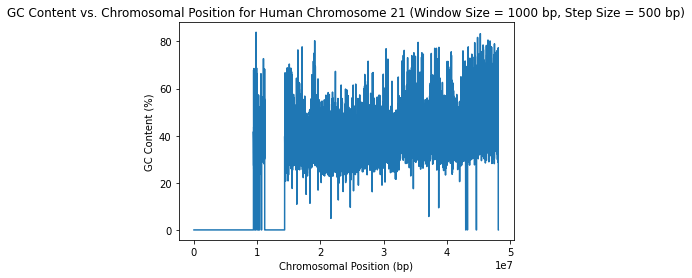

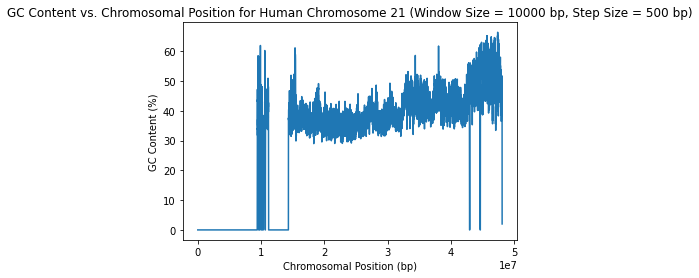

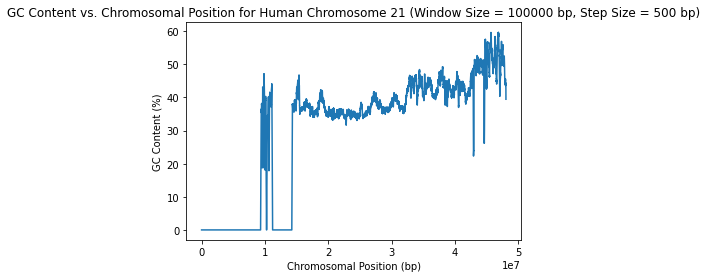

In [27]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd

file_path="C:/Users/reach/Downloads/lustre/scratch109/ensembl/tm6/fasta_dumping_human_GRCh37_e83/fasta/homo_sapiens/dna/Homo_sapiens.GRCh37.dna.chromosome.21.fasta"
# Load the human chromosome 21 sequence in FASTA format
seq_record = SeqIO.read(file_path, "fasta")

# Define the sliding window size and step
window_sizes =[1000,10000,100000]
step_size = 500

print("Problem 1 a)")

# Calculate the GC-content for each window
for window_size in window_sizes:
    gc_content = []
    for i in range(0, len(seq_record.seq) - window_size + 1, step_size):
        window = seq_record.seq[i:i+window_size]
        gc = (window.count('G') + window.count('C')) / window_size * 100
        gc_content.append(gc)

    # Generate a DataFrame of the GC-content data
    df = pd.DataFrame({"GC Content": gc_content})

    # Add a column for the chromosomal position
    df["Position"] = pd.Series(range(1, len(gc_content)+1)) * step_size

    # Create a plot of the GC-content vs. chromosomal position
    plt.plot(df["Position"], df["GC Content"])
    plt.xlabel("Chromosomal Position (bp)")
    plt.ylabel("GC Content (%)")
    plt.title("GC Content vs. Chromosomal Position for Human Chromosome 21 (Window Size = {} bp, Step Size = {} bp)".format(window_size, step_size))
    plt.show()


In [29]:
# Import required libraries
from pomegranate import *
import numpy as np
from Bio.SeqUtils import GC
from collections import defaultdict
import matplotlib.pyplot as plt

Problem 1 b)


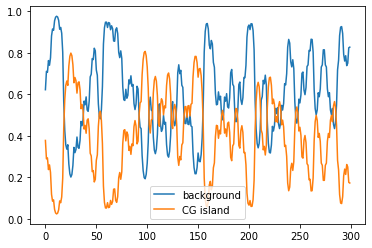

C:\Users\reach\anaconda3\lib\site-packages\Bio\SeqUtils\__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


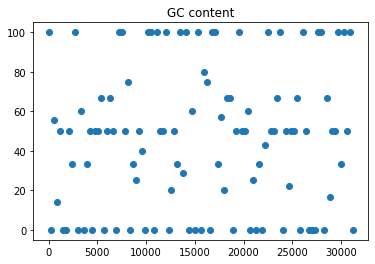

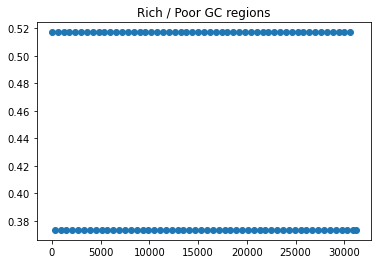

In [54]:
print("Problem 1 b)")

# Define HMM states
poor = State(DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}), name="poor")
rich = State(DiscreteDistribution({'A': 0.1, 'C': 0.1, 'G': 0.4, 'T': 0.4}), name="rich")

# Define HMM transition matrix
transition_matrix = np.array([[0.5, 0.5], [0.5, 0.5]])

# Define HMM model and add states/transitions
model = HiddenMarkovModel()
model.add_states([poor, rich])
model.add_transition(model.start, poor, .5)
model.add_transition(model.start, rich, .5)
model.add_transition(poor, poor, .9)
model.add_transition(poor, rich, .1)
model.add_transition(rich, poor, .1)
model.add_transition(rich, rich, .9)
model.bake()

# Read input sequence from FASTA file
record = SeqIO.read(file_path, "fasta")
sequence = record.seq

# Preprocess sequence data
X = str(sequence).replace('N', '').replace('n', '').replace('a', '').replace('c', '').replace('g', '').replace('t', '')
window = 300
X = X[0:window]
X = list(X)
plt.plot(model.predict_proba(X), label=['background', 'CG island'])
plt.legend()
plt.show()

# Run HMM model on preprocessed data
model.fit([X])
path = model.viterbi(X)

# Analyze HMM output and segment sequence by GC content
segments = []
current_block = ""
gc_content = None
for i in range(window):
    state = path[1][i][1].name
    if(path[1][i][1].distribution != None):
        gc_para = path[1][i][1].distribution.parameters[0]['G'] + path[1][i][1].distribution.parameters[0]['C']
    if state != gc_content:
        if gc_content:
            segments.append((gc_content, current_block, gc, gc_para))
        gc_content = state
        current_block = X[i]
        gc = GC(current_block)
    else:
        current_block += X[i]
        gc = GC(current_block)
segments.append((gc_content, current_block, gc, gc_para))

# Plot GC content and rich/poor GC regions
x_cord, y_cord, y_cord_param = [], [], []
for i, (state, segment, gc, gc_para) in enumerate(segments):
    x_cord.append(i * window + len(segment))
    y_cord.append(gc)
    y_cord_param.append(gc_para)

plt.title("GC content")
plt.plot(x_cord, y_cord, 'o')
plt.show()

plt.title("Rich / Poor GC regions")
plt.plot(x_cord, y_cord_param, 'o')
plt.show()


Parameters: 
The Hidden Markov Model used in this code has three main parameters: "poor", "rich", and "transition_matrix". These parameters are used to define the states and transitions of the model.

The "poor" and "rich" parameters are two State objects that represent GC-poor and GC-rich segments, respectively. The emission probabilities of these states are specified using DiscreteDistribution objects. The "poor" state has equal probabilities for each nucleotide ('A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25), while the "rich" state has probabilities biased towards 'G' and 'T' ('A': 0.1, 'C': 0.1, 'G': 0.4, 'T': 0.4).

The "transition_matrix" is a 2x2 numpy array that specifies the transition probabilities between the "poor" and "rich" states. In this case, the matrix is set to [[0.5, 0.5], [0.5, 0.5]], meaning that the transition probabilities from one state to another are equal and independent of the current state.

To create the Hidden Markov Model, the "poor" and "rich" states are added to the model using the add_states method, and the transitions between the states are added using the add_transition method. The model is then "baked" using the bake method to finalize its structure. Finally, the model is fitted to the input sequence X using the fit method.

Overall, the Hidden Markov Model parameters used in this code are designed to classify regions of a DNA sequence as either GC-poor or GC-rich based on their nucleotide composition.

In [55]:
from Bio import SeqIO
import numpy as np

print("Problem 2 a)")
# Read in the TFBS sequences as a list of strings
sequences = []
with open('C:/Users/reach/OneDrive/Documents/2ndSem/BioInformatics/tfbs.fasta') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        sequences.append(str(record.seq))

# Define the number of positions in the motif
num_positions = 8

# Initialize the parameters for the i.i.d. models
motif_params = np.zeros((num_positions, 4))

# Run the EM algorithm to estimate the parameters
num_iterations = 100
for i in range(num_iterations):
    # Initialize the expected counts
    expected_counts = np.zeros((num_positions, 4))
    
    # Compute the expected counts for each position and nucleotide
    for seq in sequences:
        for pos in range(num_positions):
            nucleotide = seq[pos]
            nucleotide_index = "ACGT".index(nucleotide)
            expected_counts[pos, nucleotide_index] += 1
    
    # Normalize the expected counts to obtain the frequencies
    motif_params = expected_counts / np.sum(expected_counts, axis=1, keepdims=True)
    
# Print the estimated parameters for each position in the motif
print("Estimated motif parameters:")
for pos in range(num_positions):
    print("Position {}: {}".format(pos+1, ", ".join(["{:.4f}".format(x) for x in motif_params[pos]])))


Problem 2 a)
Estimated motif parameters:
Position 1: 0.0909, 0.0909, 0.0000, 0.8182
Position 2: 0.0000, 0.0909, 0.7273, 0.1818
Position 3: 0.8182, 0.0000, 0.1818, 0.0000
Position 4: 0.0000, 0.9091, 0.0909, 0.0000
Position 5: 0.0000, 0.0909, 0.9091, 0.0000
Position 6: 0.0000, 0.0909, 0.0000, 0.9091
Position 7: 0.0909, 0.8182, 0.0909, 0.0000
Position 8: 0.6364, 0.0909, 0.0909, 0.1818


In [ ]:
Problem 2 b)
To incorporate the probabilities calculated in part (2.a) and identify potential TFBS sequences within a parent sequence, we can construct an HMM model with eight states representing the eight positions required for a TFBS to exist.
Next, we can train the model using the human chromosome 21 sequence to obtain the relative positions of potential TFBS locations. By comparing the model's predicted positions to the actual sequence using string matching, we can validate the existence of TFBS locations within the sequence.

Problem 2 c)


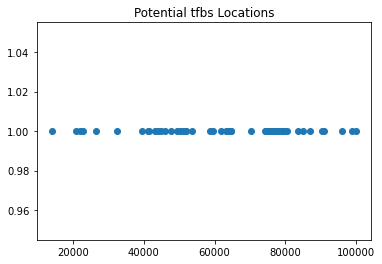

tfbs sequence found at : [13956, 20793, 21995, 22854, 26574, 32323, 39371, 41063, 41551, 43159, 44075, 44937, 45854, 47623, 49296, 50335, 50922, 51767, 52030, 53588, 58700, 59657, 61653, 63119, 63851, 64496, 64750, 70400, 74322, 74519, 74719, 74917, 75133, 75327, 75738, 75936, 76128, 76534, 76732, 76927, 77121, 77753, 77980, 78847, 79039, 79243, 79456, 80474, 83423, 84913, 86966, 90357, 90763, 96076, 98722, 99992]


In [51]:
from Bio import SeqIO
from Bio.SeqUtils import GC
import matplotlib.pyplot as plt
from collections import defaultdict
from pomegranate import *
import numpy as np

print("Problem 2 c)")
#probability
sequences = []

with open("C:/Users/reach/OneDrive/Documents/2ndSem/BioInformatics/tfbs.fasta") as f:
    for record in SeqIO.parse(f, "fasta"):
        sequences.append(str(record.seq))

length_of_sequence = len(sequences[0])
no_of_sequence = len(sequences)

prob = {}

for j in range(length_of_sequence):
    prob[j+1] = {'A': 0, 'C': 0, 'G': 0, 'T': 0}

for l in range(length_of_sequence):
    counts = defaultdict(int)
    for k in sequences:
        counts[k[l]] += 1
    for base, count in counts.items():
        prob[l+1][base] = count / no_of_sequence

#model

Normal = State(DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}), name="0")
pos_1 = State(DiscreteDistribution(prob[1]), name="1")
pos_2 = State(DiscreteDistribution(prob[2]), name="2")
pos_3 = State(DiscreteDistribution(prob[3]), name="3")
pos_4 = State(DiscreteDistribution(prob[4]), name="4")
pos_5 = State(DiscreteDistribution(prob[5]), name="5")
pos_6 = State(DiscreteDistribution(prob[6]), name="6")
pos_7 = State(DiscreteDistribution(prob[7]), name="7")
pos_8 = State(DiscreteDistribution(prob[8]), name="8")


model = HiddenMarkovModel()

model.add_states([Normal, pos_1, pos_2, pos_3, pos_4, pos_5, pos_6, pos_7, pos_8])

model.add_transition(model.start, Normal, 0.8)
model.add_transition(model.start, pos_1, 0.1)
model.add_transition(model.start, pos_2, 0.1)
model.add_transition(model.start, pos_3, 0.1)
model.add_transition(model.start, pos_4, 0.1)
model.add_transition(model.start, pos_5, 0.1)
model.add_transition(model.start, pos_6, 0.1)
model.add_transition(model.start, pos_7, 0.1)
model.add_transition(model.start, pos_8, 0.1)

model.add_transition(Normal, Normal, .8)
model.add_transition(pos_1, pos_1, .1)
model.add_transition(pos_2, pos_2, .1)
model.add_transition(pos_3, pos_3, .1)
model.add_transition(pos_4, pos_4, .1)
model.add_transition(pos_5, pos_5, .1)
model.add_transition(pos_6, pos_6, .1)
model.add_transition(pos_7, pos_7, .1)
model.add_transition(pos_8, pos_8, .1)

model.add_transition(Normal, pos_1, .2)
model.add_transition(pos_1, pos_2, .9)
model.add_transition(pos_2, pos_3, .9)
model.add_transition(pos_3, pos_4, .9)
model.add_transition(pos_4, pos_5, .9)
model.add_transition(pos_5, pos_6, .9)
model.add_transition(pos_6, pos_7, .9)
model.add_transition(pos_7, pos_8, .9)
model.add_transition(pos_8, Normal, .9)

model.bake()



#chromosome 21 fitting

record = SeqIO.read(file_path, "fasta")

sequence = record.seq

X = sequence
X = str(X).replace('N', '')
X = str(X).replace('n', '')
X = str(X).replace('a', '')
X = str(X).replace('c', '')
X = str(X).replace('g', '')
X = str(X).replace('t', '')
window = 100000
X = X[300000:400000]
X = list(X)
model.fit([X])

path = model.viterbi(X)
segments = []

for i in range(window):
    state = path[1][i][1].name
    if state != gc_content:
        if gc_content:
            segments.append((gc_content, current_block))
        gc_content = state
        current_block = X[i]
    else:
        current_block += X[i]
segments.append((gc_content, current_block))

i=0
x = 0
x_cord = []
y_cord = []
seq_start = []
seq = {}
while (i <= (len(segments)-8)):
    x += len(segments[i][1])
    if segments[i][0] == '1':
        if segments[i+1][0] == '2':
            if segments[i+2][0] == '3':
                if segments[i+3][0] == '4':
                    if segments[i+4][0] == '5':
                        if segments[i+5][0] == '6':
                            if segments[i+6][0] == '7':
                                if segments[i+7][0] == '8':
                                    seq_start.append(x)
                                    x_cord.append(x)
                                    y_cord.append(1)
                                    for s in sequences:
                                        if s in str(segments[i][1]+segments[i+1][1]+segments[i+2][1]+segments[i+3][1]+segments[i+4][1]+segments[i+5][1]+segments[i+6][1]+segments[i+7][1]):
                                            seq[s] = (segments[i][1]+segments[i+1][1]+segments[i+2][1]+segments[i+3][1]+segments[i+4][1]+segments[i+5][1]+segments[i+6][1]+segments[i+7][1])
    i +=1
plt.title("Potential tfbs Locations")
plt.plot(x_cord, y_cord, 'o')
plt.show()
print("tfbs sequence found at :", seq_start)